In [1]:
import pandas as pd
import numpy as np
from typing import Any
from tqdm import tqdm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import odr
from scipy.stats import median_abs_deviation
import pickle
import os
import time
import seaborn as sns
sns.set_theme()

from utils import *

import matplotlib.pyplot as plt

LEVEL = 'client'  # 'member' or 'client'
N = 1
RECOMPUTE = True

column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}


### Intro

Now I start to preprocess the dataframes

In [2]:
PATH_DATA_FOLDER = "C:/Users/User01/Documents/di_nosse/MOT"
PATH_NEW_DATA_FOLDER = "C:/Users/User01/Documents/di_nosse/MOT_NEW"

if os.path.exists(PATH_NEW_DATA_FOLDER) is False:
    os.mkdir(PATH_NEW_DATA_FOLDER)

dfs_paths = [PATH_DATA_FOLDER + '/' + path for path in os.listdir(PATH_DATA_FOLDER) if (path.endswith('.csv')) and (path != 'ALTRI_FTSEMIB.csv') and (path != 'MOT.csv')]
isins = [path.split('.')[0] for path in os.listdir(PATH_DATA_FOLDER) if (path.endswith('.csv')) and (path != 'ALTRI_FTSEMIB.csv') and (path != 'MOT.csv')]
print(dfs_paths)
print(isins)

['C:/Users/User01/Documents/di_nosse/MOT/IT0003934657.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005083057.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005217390.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005273013.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005358806.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005363111.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005425233.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005438004.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005441883.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005480980.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005496770.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005530032.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005534141.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005582421.csv', 'C:/Users/User01/Documents/di_nosse/MOT/IT0005583486.csv']
['IT0003934657', 'IT0005083057', 'IT0005217390', 'IT0005273013', 'IT0005358806', 'IT0005363111', 'IT0005425233', '

One of the original data sets

In [3]:
df = pd.read_csv(dfs_paths[1], sep=';')
df

,ISIN,MIC,EXECUTION_PHASE,TRADING_DAY,TRADETIME,TRADED_QUANTITY,TRADED_PRICE,TRADED_AMOUNT,TRADE_CANCELLATION_INDICATOR,COD_BUY,CLIENT_IDENTIFIC_SHORT_CODE_BUY,PASSIVE_ORDER_INDICATOR_BUY,COD_SELL,CLIENT_IDENTIFIC_SHORT_CODE_SELL,PASSIVE_ORDER_INDICATOR_SELL,TRADING_CAPACITY_BUY,TRADING_CAPACITY_SELL
0,IT0005083057,MOTX,1,12/03/2025,17:27:07.305091581,20000,83.78,16756.0,0,96976,33243051,1,117171,0,0,3,1
1,IT0005083057,MOTX,1,17/12/2024,12:36:14.586993758,100000,91.76,91760.0,0,117416,201820325,1,117171,0,0,3,1
2,IT0005083057,MOTX,1,17/12/2024,12:36:42.812827154,100000,91.76,91760.0,0,117416,201820325,1,117171,0,0,3,1
3,IT0005083057,MOTX,1,27/03/2025,17:01:19.663283060,2000,84.45,1689.0,0,117416,200298991,1,117171,0,0,3,1
4,IT0005083057,MOTX,1,17/12/2024,12:36:14.586993758,30000,91.76,27528.0,0,117416,201820325,1,117171,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95944,IT0005083057,MOTX,1,19/12/2024,10:20:44.026767465,200000,91.09,182180.0,0,96895,0,1,116250,0,0,1,1
95945,IT0005083057,MOTX,1,30/12/2024,11:46:43.751615848,100000,89.96,89960.0,0,96895,0,1,116250,0,0,1,1
95946,IT0005083057,MOTX,1,19/12/2024,10:20:44.026767465,10000,91.13,9113.0,0,96922,0,1,116250,0,0,1,1
95947,IT0005083057,MOTX,1,19/12/2024,10:20:44.026767465,20000,91.10,18220.0,0,96894,1026092998,1,116250,0,0,3,1


Transform the original datasets

In [4]:
for path in dfs_paths:
    new_path = PATH_NEW_DATA_FOLDER + '/' + os.path.basename(path).split('.')[0] + '.parquet'
    if os.path.exists(new_path):
        print(f"Transformed file for {new_path} already exists. Skipping...")
        continue
    print(f"Processing {path}...")
    df = pd.read_csv(path, sep=';')
    df_mapped = map_trade_codes(df)
    df_transformed = build_trades_view(df_mapped)
    if len(df_transformed[(df_transformed['Total Quantity Buy'] > 0) & (df_transformed['Total Quantity Sell'] > 0)]) > 0:
        print(f"Warning: Both Buy and Sell quantities greater than zero found in {path}. Check data integrity.")
    # display(df_transformed)
    df_transformed.to_parquet(new_path)
    print(f"Saved transformed data to {new_path}.")

Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0003934657.parquet already exists. Skipping...
Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005083057.parquet already exists. Skipping...
Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005217390.parquet already exists. Skipping...
Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005273013.parquet already exists. Skipping...
Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005358806.parquet already exists. Skipping...
Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005363111.parquet already exists. Skipping...
Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005425233.parquet already exists. Skipping...
Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005438004.parquet already exists. Skipping...
Transformed file for C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005441883.parquet already exi

One of te new dataset

In [5]:
df = pd.read_parquet('C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0003934657.parquet')
df

,ID Client,ID Member,Trading Venue,Trade Time,Direction,Price First Contract,Price Last Contract,Total Quantity Buy,Total Quantity Sell,Total Amount Buy,Total Amount Sell,Trade Type Aggressive
0,1126,96873,MOTX,2024-06-03 09:00:17.495386862,1,100.04,100.04,16000,0,16006.4,0.0,Any_other_capacity
1,46416,96965,MOTX,2024-06-03 09:00:17.495386862,1,100.04,100.04,60000,0,60024.0,0.0,Any_other_capacity
2,202554213,117416,MOTX,2024-06-03 09:00:17.495386862,1,100.04,100.04,100000,0,100040.0,0.0,Any_other_capacity
3,202823889,117416,MOTX,2024-06-03 09:00:17.495386862,1,100.04,100.04,7000,0,7002.8,0.0,Any_other_capacity
4,203159461,117416,MOTX,2024-06-03 09:00:17.495386862,1,100.04,100.04,10000,0,10004.0,0.0,Any_other_capacity
...,...,...,...,...,...,...,...,...,...,...,...,...
135428,201554742,117416,MOTX,2025-05-30 17:24:22.850960836,1,104.41,104.41,10000,0,10441.0,0.0,Any_other_capacity
135429,14039,96871,MOTX,2025-05-30 17:24:50.721857989,-1,104.40,104.40,0,25000,0.0,26100.0,Any_other_capacity
135430,1126,96873,MOTX,2025-05-30 17:25:27.317645332,1,104.41,104.41,10000,0,10441.0,0.0,Any_other_capacity
135431,46416,96965,MOTX,2025-05-30 17:25:29.908063518,1,104.41,104.41,20000,0,20882.0,0.0,Any_other_capacity


In [6]:
dfs_path_new = [PATH_NEW_DATA_FOLDER + '/' + path for path in os.listdir(PATH_NEW_DATA_FOLDER) if (path.endswith('.parquet'))]
dfs_path_new

['C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0003934657.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005083057.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005217390.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005273013.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005358806.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005363111.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005425233.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005438004.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005441883.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005480980.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005496770.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005530032.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005534141.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0005582421.parquet',
 'C:/Users/User01/Documents/di_nosse/MOT_NEW/IT0

In [7]:
random_path = np.random.choice(dfs_path_new)
df = pd.read_parquet(random_path)
if len(df[(df['Total Quantity Buy'] > 0) & (df['Total Quantity Sell'] > 0)]) > 0:
        print(f"Warning: Both Buy and Sell quantities greater than zero found in {random_path}. Check data integrity.")


### Metaorder computation

In this cell I compute the time series of the metaorders (consecutive trades of the same sign, performed by the same broker for the same client). I use here only trades not made as proprietary trades. The metaorders are evaluated wrt the broker here.

In [8]:
if os.path.exists(f'out_files/metaorders_dict_all_nofilter_mot_{LEVEL}.pkl') and RECOMPUTE==False:
    print(f"Loading metaorders_dict_all_nofilter_mot_{LEVEL}.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_nofilter_mot_{LEVEL}.pkl')
    print('Done.')
else:
    metaorders_dict_all = {isin:{} for isin in isins}
    for i, path in enumerate(dfs_path_new):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        # Select the corresponding metaorders_dict (now empty)
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        trades_members_numpy = trades_members.to_numpy()

        # If metaorders must be tracked wrt to the final client, use 'Id Client' instead of 'Id Member' in agents_activity
        column_positions = {'Trade Time': 3, 'ID Member': 1, 'ID Client': 0, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8}
        print('    Evaluating agents activity...')
        # agents_dict, _, _, _ = agents_activity(trades_members_numpy, column_positions, level=LEVEL)
        indices_by_agent, act_by_agent = agents_activity_sparse(trades_members_numpy, column_positions, level=LEVEL)
        print('    Done.')

        # ---------- Reusable dense buffer aligned to all trades ----------
        n_trades = len(trades_members_numpy)
        act_dense = np.zeros(n_trades, dtype=np.int8)

        # ---------- Per-agent metaorders ----------
        for aid in tqdm(indices_by_agent.keys(), desc="    Processing agents"):
            idxs = indices_by_agent[aid]
            signs = act_by_agent[aid]

            if idxs.size == 0:
                continue

            # Fill only the touched locations; rest remains zero
            act_dense[idxs] = signs

            # Find metaorders (constant sign runs in the reduced sequence)
            _, metaorders_original_indexes, n_metaorders = find_metaorders(act_dense, min_child=2)
            if n_metaorders == 0:
                act_dense[idxs] = 0  # reset
                continue

            # Filter: single-child, cross-day, multi-client
            kept = []
            for meta_idx_list in metaorders_original_indexes:
                if len(meta_idx_list) < 2:
                    continue

                # Time constraint: same day
                t_start = pd.Timestamp(trades_members_numpy[meta_idx_list[0], column_positions["Trade Time"]])
                t_end   = pd.Timestamp(trades_members_numpy[meta_idx_list[-1], column_positions["Trade Time"]])
                if t_start.date() != t_end.date():
                    continue

                # Single-client constraint (redundant if level=='client', but kept for safety)
                clients = np.unique(trades_members_numpy[meta_idx_list, column_positions["ID Client"]])
                if len(clients) > 1:
                    continue

                kept.append(meta_idx_list)

            if kept:
                metaorders_dict[aid] = kept

            # Reset only the positions we set (cheap)
            act_dense[idxs] = 0

        # Save back for this ISIN
        metaorders_dict_all[isin] = metaorders_dict

        # Summary
        total_number_metaorders = sum(len(v) for v in metaorders_dict.values())
        print(f"    Total number of metaorders ({isin}): {total_number_metaorders}")

        # Free a bit
        del trades_members, trades_members_numpy, indices_by_agent, act_by_agent, act_dense
        gc.collect()

    #Save on file the metaorders_dict_all without filtering
    print(f"Saving metaorders_dict_all_nofilter_mot_{LEVEL}.pkl...")
    pd.to_pickle(metaorders_dict_all, f'out_files/metaorders_dict_all_nofilter_mot_{LEVEL}.pkl')
    print("Done.")


(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 17357/17357 [00:05<00:00, 3259.54it/s]


    Total number of metaorders (IT0003934657): 9116
(2/15) Processing ISIN IT0005083057...
    Loading trades data...
   67738 trades loaded.
    Done.
    34289 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 6107/6107 [00:00<00:00, 7874.78it/s]


    Total number of metaorders (IT0005083057): 1940
(3/15) Processing ISIN IT0005217390...
    Loading trades data...
   124738 trades loaded.
    Done.
    66254 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 6961/6961 [00:01<00:00, 4493.24it/s]


    Total number of metaorders (IT0005217390): 5237
(4/15) Processing ISIN IT0005273013...
    Loading trades data...
   92820 trades loaded.
    Done.
    50585 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 8565/8565 [00:01<00:00, 5388.50it/s]


    Total number of metaorders (IT0005273013): 3006
(5/15) Processing ISIN IT0005358806...
    Loading trades data...
   99025 trades loaded.
    Done.
    65900 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 15850/15850 [00:03<00:00, 4846.50it/s]


    Total number of metaorders (IT0005358806): 2382
(6/15) Processing ISIN IT0005363111...
    Loading trades data...
   129570 trades loaded.
    Done.
    73751 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 11461/11461 [00:02<00:00, 4007.30it/s]


    Total number of metaorders (IT0005363111): 4390
(7/15) Processing ISIN IT0005425233...
    Loading trades data...
   141844 trades loaded.
    Done.
    75887 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 8015/8015 [00:02<00:00, 3911.34it/s]


    Total number of metaorders (IT0005425233): 6607
(8/15) Processing ISIN IT0005438004...
    Loading trades data...
   58730 trades loaded.
    Done.
    30508 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 4421/4421 [00:00<00:00, 8515.93it/s]


    Total number of metaorders (IT0005438004): 1906
(9/15) Processing ISIN IT0005441883...
    Loading trades data...
   185801 trades loaded.
    Done.
    111785 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 11369/11369 [00:03<00:00, 3019.61it/s]


    Total number of metaorders (IT0005441883): 10359
(10/15) Processing ISIN IT0005480980...
    Loading trades data...
   62799 trades loaded.
    Done.
    27018 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 3060/3060 [00:00<00:00, 7626.13it/s]


    Total number of metaorders (IT0005480980): 1714
(11/15) Processing ISIN IT0005496770...
    Loading trades data...
   59577 trades loaded.
    Done.
    32615 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 7659/7659 [00:01<00:00, 7607.43it/s]


    Total number of metaorders (IT0005496770): 1302
(12/15) Processing ISIN IT0005530032...
    Loading trades data...
   63843 trades loaded.
    Done.
    26544 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 3963/3963 [00:00<00:00, 8973.97it/s]


    Total number of metaorders (IT0005530032): 1485
(13/15) Processing ISIN IT0005534141...
    Loading trades data...
   154098 trades loaded.
    Done.
    66535 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 8442/8442 [00:01<00:00, 4877.43it/s]


    Total number of metaorders (IT0005534141): 4929
(14/15) Processing ISIN IT0005582421...
    Loading trades data...
   72447 trades loaded.
    Done.
    36730 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 7814/7814 [00:01<00:00, 7737.85it/s]


    Total number of metaorders (IT0005582421): 1575
(15/15) Processing ISIN IT0005583486...
    Loading trades data...
   48939 trades loaded.
    Done.
    37081 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.


    Processing agents: 100%|██████████| 11961/11961 [00:01<00:00, 7619.17it/s]


    Total number of metaorders (IT0005583486): 1641
Saving metaorders_dict_all_nofilter_mot_client.pkl...
Done.


In [9]:
MAX_GAP = pd.Timedelta(hours=1)        # soglia di 1 h
MIN_TRADES = 2

if os.path.exists(f'out_files/metaorders_dict_all_mot_{LEVEL}.pkl') and RECOMPUTE==False:
    print(f"Loading filtered metaorders_dict_all_mot_{LEVEL}.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_mot_{LEVEL}.pkl')
    print('Done')
else:
    print(f"Loading unfiltered metaorders_dict_all_nofilter_mot_{LEVEL}.pkl...")
    metaorders_dict_all = pd.read_pickle(f'out_files/metaorders_dict_all_nofilter_mot_{LEVEL}.pkl')

    # ---- constants (nanosecond precision for intraday filter) ----
    S_NS  = np.int64(1_000_000_000)
    M_NS  = np.int64(60) * S_NS
    H_NS  = np.int64(60) * M_NS
    DAY_NS = np.int64(24) * H_NS

    START_NS = np.int64(9) * H_NS + np.int64(30) * M_NS           # 09:30:00.000
    END_NS   = np.int64(17) * H_NS + np.int64(30) * M_NS          # 17:30:00.000

    # Convert MAX_GAP to numpy timedelta64[ns] once (fast comparisons later)
    try:
        max_gap_np = MAX_GAP.to_numpy()
    except AttributeError:
        max_gap_np = np.timedelta64(int(MAX_GAP.value), 'ns')

    for i, path in enumerate(dfs_path_new):
        isin = os.path.splitext(os.path.basename(path))[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")

        # alias to avoid repeated dictionary lookups in inner loops
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        # Read only needed columns to reduce IO/memory
        trades_members = pd.read_parquet(path, columns=['Trade Time', 'Trade Type Aggressive'])
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # --- vectorized filter: exclude proprietary + keep [09:30:00, 17:30:00] EXACTLY ---
        tta = trades_members['Trade Type Aggressive'].values
        tm = trades_members['Trade Time']

        # Fast intraday nanoseconds since midnight, preserving timezone semantics:
        # If tz-naive -> use int64 view (ns since epoch) % DAY_NS
        # If tz-aware -> compute from components (hour/min/sec/micro/nano) to avoid UTC shifts
        if tm.dt.tz is None:
            # pandas 2.x: Series.view('i8') works for tz-naive datetime64[ns]
            ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
        else:
            ns_since_midnight = (
                tm.dt.hour.astype(np.int64)   * H_NS +
                tm.dt.minute.astype(np.int64) * M_NS +
                tm.dt.second.astype(np.int64) * S_NS +
                tm.dt.microsecond.astype(np.int64) * np.int64(1_000) +
                tm.dt.nanosecond.astype(np.int64)
            )

        # Inclusive bounds, matching .dt.time.between(..., inclusive='both'):
        in_hours = (ns_since_midnight >= START_NS) & (ns_since_midnight <= END_NS)
        mask = (tta != 'Dealing_on_own_account') & in_hours
        trades_members = trades_members.loc[mask].copy()

        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members.reset_index(drop=True, inplace=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)

        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        # Pre-extract the numpy array of times for fast slicing
        times_arr = trades_members['Trade Time'].to_numpy()

        # ---------------------------------------------------------------------
        # loop sui broker/members: split su gap > 1h
        # ---------------------------------------------------------------------
        for member_id, meta_list in metaorders_dict.items():
            new_metaorders = []
            append_nm = new_metaorders.append

            for meta in meta_list:
                if len(meta) < 2:
                    append_nm(meta)
                    continue

                idx_arr = np.asarray(meta, dtype=np.int64)
                ts = times_arr[idx_arr]
                diffs = ts[1:] - ts[:-1]

                split_idx = np.flatnonzero(diffs > max_gap_np)
                if split_idx.size == 0:
                    parts = [idx_arr]
                else:
                    # np.split expects indices after the cut; add 1
                    parts = np.split(idx_arr, split_idx + 1)

                # aggiungi solo i segmenti di lunghezza >= MIN_TRADES
                for part in parts:
                    if part.size >= MIN_TRADES:
                        append_nm(part.tolist())

            metaorders_dict[member_id] = new_metaorders

        # --- stampa il numero totale di meta-ordini per questo btp -------------
        total_meta = sum(len(metas) for metas in metaorders_dict.values())
        print(f"{isin}: {total_meta} metaorders")

    # salva su file
    print(f"Saving filtered metaorders_dict_all_mot_{LEVEL}.pkl...")
    pd.to_pickle(metaorders_dict_all, f'out_files/metaorders_dict_all_mot_{LEVEL}.pkl')
    print("Done.")


C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


Loading unfiltered metaorders_dict_all_nofilter_mot_client.pkl...
(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.
IT0003934657: 8620 metaorders
(2/15) Processing ISIN IT0005083057...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


   67738 trades loaded.
    Done.
    34289 trades after filtering out proprietary trades and outside trading hours.
IT0005083057: 1795 metaorders
(3/15) Processing ISIN IT0005217390...
    Loading trades data...
   124738 trades loaded.
    Done.
    66254 trades after filtering out proprietary trades and outside trading hours.
IT0005217390: 4930 metaorders
(4/15) Processing ISIN IT0005273013...
    Loading trades data...
   92820 trades loaded.
    Done.
    50585 trades after filtering out proprietary trades and outside trading hours.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


IT0005273013: 2871 metaorders
(5/15) Processing ISIN IT0005358806...
    Loading trades data...
   99025 trades loaded.
    Done.
    65900 trades after filtering out proprietary trades and outside trading hours.
IT0005358806: 2262 metaorders
(6/15) Processing ISIN IT0005363111...
    Loading trades data...
   129570 trades loaded.
    Done.
    73751 trades after filtering out proprietary trades and outside trading hours.
IT0005363111: 4295 metaorders
(7/15) Processing ISIN IT0005425233...
    Loading trades data...
   141844 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    75887 trades after filtering out proprietary trades and outside trading hours.
IT0005425233: 6238 metaorders
(8/15) Processing ISIN IT0005438004...
    Loading trades data...
   58730 trades loaded.
    Done.
    30508 trades after filtering out proprietary trades and outside trading hours.
IT0005438004: 1628 metaorders
(9/15) Processing ISIN IT0005441883...
    Loading trades data...
   185801 trades loaded.
    Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


    111785 trades after filtering out proprietary trades and outside trading hours.
IT0005441883: 9795 metaorders
(10/15) Processing ISIN IT0005480980...
    Loading trades data...
   62799 trades loaded.
    Done.
    27018 trades after filtering out proprietary trades and outside trading hours.
IT0005480980: 1657 metaorders
(11/15) Processing ISIN IT0005496770...
    Loading trades data...
   59577 trades loaded.
    Done.
    32615 trades after filtering out proprietary trades and outside trading hours.
IT0005496770: 1170 metaorders
(12/15) Processing ISIN IT0005530032...
    Loading trades data...


C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change

   63843 trades loaded.
    Done.
    26544 trades after filtering out proprietary trades and outside trading hours.
IT0005530032: 1371 metaorders
(13/15) Processing ISIN IT0005534141...
    Loading trades data...
   154098 trades loaded.
    Done.
    66535 trades after filtering out proprietary trades and outside trading hours.
IT0005534141: 4768 metaorders
(14/15) Processing ISIN IT0005582421...
    Loading trades data...
   72447 trades loaded.
    Done.
    36730 trades after filtering out proprietary trades and outside trading hours.
IT0005582421: 1387 metaorders
(15/15) Processing ISIN IT0005583486...
    Loading trades data...
   48939 trades loaded.
    Done.
    37081 trades after filtering out proprietary trades and outside trading hours.
IT0005583486: 1437 metaorders
Saving filtered metaorders_dict_all_mot_client.pkl...
Done.


C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)
C:\Users\dinosse\AppData\Local\Temp\ipykernel_5124\1517993676.py:49: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ns_since_midnight = (tm.view('i8') % DAY_NS).astype(np.int64)


Check that all the metaorders identified have consistent signs

In [10]:
try:
    with open(f'out_files/metaorders_dict_all_mot_{LEVEL}.pkl', 'rb') as f:
        metaorders_dict_all = pickle.load(f)
except FileNotFoundError:
    print("metaorders_dict_all_nofilter file not found. Please run the metaorders identification script first.")
    exit(1)
for i, path in enumerate(dfs_path_new):
    isin = path.split('/')[-1].split('.')[0]
    trades_members = pd.read_parquet(f'{path}')

    # consider only trades not executed as proprietary trades
    trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
    trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
    # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
    trades_members = trades_members.reset_index(drop=True)
    trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
    trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
    trades_members.reset_index(drop=True, inplace=True)

    for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
        for i in range(len(metaorders_dict_all[isin][id])): # for all member id metaorders
            if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['Direction'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['Direction']):
                print('There is a sign problem')
                print(trades_members.iloc[metaorders_dict_all[isin][id][i]])
            if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['ID Client'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['ID Client']):
                print('There is a client problem')
                print(trades_members.iloc[metaorders_dict_all[isin][id][i]])
            if not np.all(trades_members.iloc[metaorders_dict_all[isin][id][i]]['ID Member'].values == trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['ID Member']):
                print('There is a member problem')
                print(trades_members.iloc[metaorders_dict_all[isin][id][i]])

IT0005583486 Agents: 100%|██████████| 231/231 [00:01<00:00, 146.20it/s]


### Some statistics about metaorders

Number of metaorders per ID Member

(1/15) Processing ISIN IT0003934657...


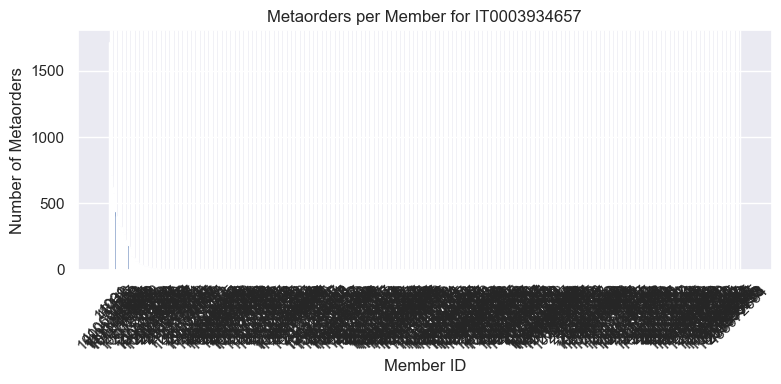

In [11]:
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
    meta_dict = metaorders_dict_all.get(isin, {})
    # Create a list of tuples (member_id, count)
    data = [(member, len(metaorders)) for member, metaorders in meta_dict.items()]
    # Sort by count (ascending, change reverse=True for descending)
    data_sorted = sorted(data, key=lambda x: x[1], reverse=True)
    sorted_member_ids, sorted_counts = zip(*data_sorted) if data_sorted else ([], [])
    
    # Create colors, coloring the bar corresponding to member 10153 in red
    # colors = ["red" if member == 10153 else "skyblue" for member in sorted_member_ids]
    
    plt.figure(figsize=(8,4))
    plt.bar([str(mid) for mid in sorted_member_ids], sorted_counts)#, color=colors)
    plt.title(f'Metaorders per Member for {isin}')
    plt.xlabel('Member ID')
    plt.ylabel('Number of Metaorders')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Longest metaorder per ISIN

(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.
    Evaluating agents activity...
    Done.
(IT0003934657) Member id with the longest metaorder: 1000004133
(IT0003934657) Lenght: 19
(IT0003934657) Longest metaorder indexes: [83564, 83569, 83578, 83582, 83586, 83593, 83648, 83654, 83663, 83709, 83710, 83715, 83721, 83722, 83725, 83726, 83730, 83736, 83747]


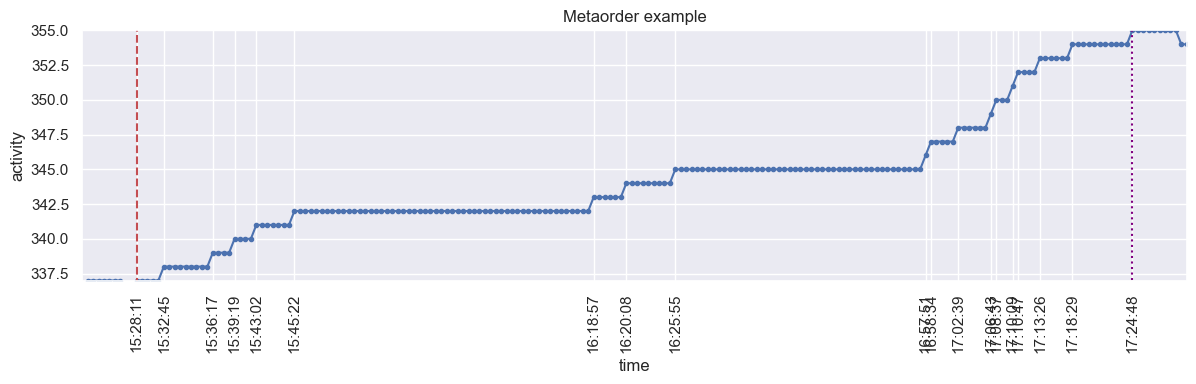

In [12]:
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
    # Select the corresponding metaorders_dict (now empty)
    metaorders_dict = metaorders_dict_all[isin]

    print('    Loading trades data...')
    trades_members = pd.read_parquet(f'{path}')
    print(f'   {len(trades_members)} trades loaded.')
    print('    Done.')

    # consider only trades not executed as proprietary trades
    trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
    trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
    # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
    trades_members = trades_members.reset_index(drop=True)
    trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
    trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
    trades_members.reset_index(drop=True, inplace=True)
    print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
    trades_members_numpy = trades_members.to_numpy()

    # If metaorders must be tracked wrt to the final client, use 'Id Client' instead of 'Id Member' in agents_activity
    column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
    print('    Evaluating agents activity...')
    indices_by_agent, act_by_agent = agents_activity_sparse(trades_members_numpy, column_positions, level=LEVEL)
    print('    Done.')
    
    metaorders_dict = metaorders_dict_all[isin]
    # Get the key whose metaorders_dict[key][1] list is the longest
    max_key = max(metaorders_dict, key=lambda k: len(metaorders_dict[k]))
    longest_metaorders_values = metaorders_dict[max_key]

    # Among these, select the longest inner list
    longest_list = max(longest_metaorders_values, key=len)

    print(f"({isin}) Member id with the longest metaorder:", max_key)
    print(f"({isin}) Lenght:", len(longest_list))
    print(f"({isin}) Longest metaorder indexes:", longest_list)
    
    # Build dense activity array for this agent
    n_trades = len(trades_members_numpy)
    act_dense = np.zeros(n_trades, dtype=np.int8)
    idxs = indices_by_agent[max_key]
    signs = act_by_agent[max_key]
    if len(idxs) > 0:
        act_dense[idxs] = signs

    timestamps = trades_members.loc[longest_list, 'Trade Time']
    plt.figure(figsize=(12,4), tight_layout=True)
    plt.plot(np.cumsum(act_dense), marker='o', markersize=3)  # plot the activity
    plt.vlines(longest_list[0], np.cumsum(act_dense).min(), np.cumsum(act_dense).max(), color='r', linestyles='dashed')  # plot the metaorders starts
    plt.vlines(longest_list[-1], np.cumsum(act_dense).min(), np.cumsum(act_dense).max(), color='purple', linestyles='dotted')  # plot the metaorders ends
    # plt.title(f"Longest metaorders in {isin} (agent {max_key})")
    plt.title(f"Metaorder example")
    plt.xlim(longest_list[0] - 10 ,longest_list[-1] + 10)
    plt.ylim(np.cumsum(act_dense)[longest_list[0]], np.cumsum(act_dense)[longest_list[-1]])
    plt.xticks(longest_list, timestamps.dt.strftime('%H:%M:%S'), rotation=90)
    plt.xlabel(f'time')
    plt.ylabel('activity')
    plt.show()
    print()

Distribution of total metaorder duration per ISIN

(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.
Max duration: 5.90 (hours)


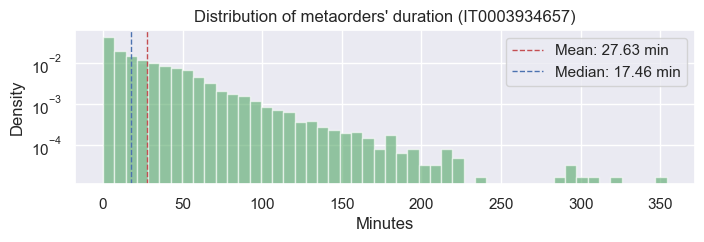

In [13]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    if os.path.exists(f'out_files/{isin}_metaorders_durations_{LEVEL}.npy') and RECOMPUTE==False:
        print(f"Metaorders durations for {isin} already computed.")
        durations = np.load(f'out_files/{isin}_metaorders_durations_{LEVEL}.npy')
        mean = np.mean(durations)
        median = np.median(durations)
    else:
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        # Select the corresponding metaorders_dict (now empty)
        metaorders_dict = metaorders_dict_all[isin]

        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        start_idxs, end_idxs = [], []
        for id in metaorders_dict_all[isin].keys():
            start_idxs = start_idxs + [metaorders_dict_all[isin][id][i][0] for i in range(len(metaorders_dict_all[isin][id]))]
            end_idxs = end_idxs + [metaorders_dict_all[isin][id][i][-1] for i in range(len(metaorders_dict_all[isin][id]))]

        start_times = [trades_members.iloc[str_idx, column_positions['Trade Time']] for str_idx in start_idxs]
        end_times = [trades_members.iloc[end_idx, column_positions['Trade Time']] for end_idx in end_idxs]

        durations = [(end - start).total_seconds() for start, end in zip(start_times, end_times) if start.date() == end.date()]
        durations = np.array(durations)

        np.save(f'out_files/{isin}_metaorders_durations_{LEVEL}.npy', durations)

        mean = np.mean(durations)
        median = np.median(durations)
    
    print(f'Max duration: {np.max(durations)/60/60:.2f} (hours)')

    plt.figure(figsize=(8,2))
    plt.hist(durations/60, bins=50, density=True, alpha=0.6, color='g')
    plt.axvline(mean/60, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean/60:.2f} min')
    plt.axvline(median/60, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median/60:.2f} min')
    plt.title(f"Distribution of metaorders' duration ({isin})")
    plt.xlabel('Minutes')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

Distribution of inter arrival times

(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.


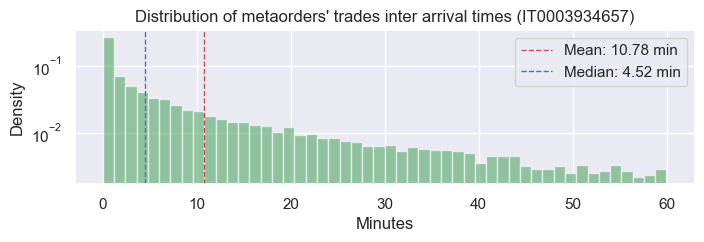

In [14]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    if os.path.exists(f'out_files/{isin}_metaorders_inter_times_{LEVEL}.npy') and RECOMPUTE==False:
        print(f"Metaorders inter times for {isin} already computed.")
        inter_times = np.load(f'out_files/{isin}_metaorders_inter_times_{LEVEL}.npy')
        mean = np.mean(inter_times)
        median = np.median(inter_times)
    else:
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        inter_times = []
        for id in metaorders_dict_all[isin].keys(): # for all members
            for i in range(len(metaorders_dict_all[isin][id])): # for all the metaorders of member id
                inter_times = inter_times + [(trades_members.iloc[metaorders_dict_all[isin][id][i][j+1], column_positions['Trade Time']] - trades_members.iloc[metaorders_dict_all[isin][id][i][j] , column_positions['Trade Time']]).total_seconds() for j in range(len(metaorders_dict_all[isin][id][i]) - 1)]

        inter_times = np.array(inter_times)

        np.save(f'out_files/{isin}_metaorders_inter_times_{LEVEL}.npy', inter_times)

        mean = np.mean(inter_times)
        median = np.median(inter_times)

    plt.figure(figsize=(8,2))
    plt.hist(inter_times/60, bins=50, density=True, alpha=0.6, color='g')
    plt.axvline(mean/60, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean/60:.2f} min')
    plt.axvline(median/60, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median/60:.2f} min')
    plt.title(f"Distribution of metaorders' trades inter arrival times ({isin})")
    plt.xlabel('Minutes')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

Distributions of total volume per metaorder for each ISIN

(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.


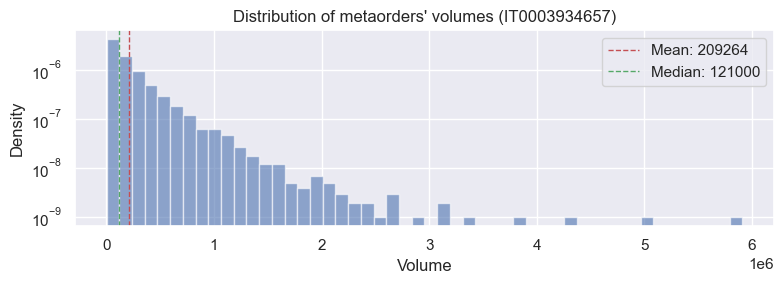

In [15]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    if os.path.exists(f'out_files/{isin}_metaorders_volume_{LEVEL}.npy') and RECOMPUTE==False:
        print(f"Metaorders inter times for {isin} already computed.")
        metaroder_volumes = np.load(f'out_files/{isin}_metaorders_volume_{LEVEL}.npy')
    else:
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        metaorder_volumes = []
        for id in metaorders_dict_all[isin].keys():
            metaorder_volumes = metaorder_volumes + [trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].values.flatten().sum() for i in range(len(metaorders_dict_all[isin][id]))]
        
        metaorder_volumes = np.array(metaorder_volumes)
        np.save(f'out_files/{isin}_metaorders_volumes_{LEVEL}.npy', metaorder_volumes)

    plt.figure(figsize=(8,3), tight_layout=True)
    plt.hist(metaorder_volumes, bins=50, density=True, alpha=0.6, color='b')
    plt.axvline(np.mean(metaorder_volumes), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(metaorder_volumes):.0f}')
    plt.axvline(np.median(metaorder_volumes), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(metaorder_volumes):.0f}')
    plt.title(f"Distribution of metaorders' volumes ({isin})")
    plt.xlabel('Volume')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

Distribution of daily traded volume

Computing daily traded volumes...
(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.


    Processing days: 100%|██████████| 251/251 [00:09<00:00, 26.83it/s]


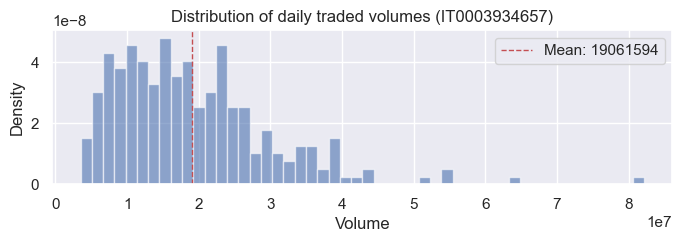

In [16]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
if os.path.exists(f'out_files/daily_traded_volume_{LEVEL}.npy') and RECOMPUTE==False:
    print("Daily traded volumes already computed.")
    daily_traded_volume = np.load(f'out_files/daily_traded_volume_{LEVEL}.npy', allow_pickle=True)
else:
    print("Computing daily traded volumes...")
    daily_traded_volume = {}
    for i, path in enumerate(dfs_path_new[:N]):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        daily_traded_volume[isin] = {}
        unique_days = sorted(trades_members['Trade Time'].dt.date.unique())

        for day in tqdm(unique_days, desc='    Processing days'):
            day_trades_members = trades_members[trades_members['Trade Time'].dt.date == day].sort_values('Trade Time').reset_index(drop=True)
            daily_vol = day_trades_members[['Total Quantity Buy', 'Total Quantity Sell']].values.flatten().sum()
            daily_traded_volume[isin][day] = (daily_vol)
    np.save(f'out_files/daily_traded_volume_{LEVEL}.npy', daily_traded_volume)

for isin in isins[:N]:
    plt.figure(figsize=(8,2))
    plt.hist(list(daily_traded_volume[isin].values()), bins=50, density=True, alpha=0.6, color='b')
    plt.axvline(np.mean(list(daily_traded_volume[isin].values())), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(list(daily_traded_volume[isin].values())):.0f}')
    plt.title(f"Distribution of daily traded volumes ({isin})")
    plt.xlabel('Volume')
    plt.ylabel('Density')
    # plt.yscale('log')
    plt.legend()
    plt.show()

Distribution of Q/V

In [17]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}

if os.path.exists(f'out_files/metaorder_volumes_dates_{LEVEL}.npy') and RECOMPUTE==False:
    print(f"Metaorders inter times for {isin} already computed.")
    metaorder_volumes_dates = np.load(f'out_files/metaorder_volumes_dates_{LEVEL}.npy')
else:
    print(f"Computing metaorders volumes and dates...")
    metaorder_volumes_dates = {isin: None for isin in isins}
    for i, path in enumerate(dfs_path_new[:N]):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].copy()
        # Deterministic, stable order: sort by time, then by original row order as a tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')
        unique_days = sorted(trades_members['Trade Time'].dt.date.unique())
        # daily_volumes = []
        # for day in np.unique(trades_members['Trade Time'].dt.date):
        #     df_day = trades_members[trades_members['Trade Time'].dt.date == day]
        #     day_volume = df_day[['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
        #     daily_volumes.append(day_volume)
        # average_daily_vol = np.mean(daily_volumes)

        metaorder_volumes_dates[isin] = {}
        ratios = []
        for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
            l = []
            for i in range(len(metaorders_dict_all[isin][id])):
                vol = trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
                date = trades_members.iloc[metaorders_dict_all[isin][id][i][0]]['Trade Time'].date()
                # idx = bisect_left(unique_days, date)
                # if idx > 0:
                #     previous_day = unique_days[idx - 1]
                # else:
                #     previous_day = date
                # day = previous_day
                trades_members_filtered = trades_members[trades_members['Trade Time'].dt.date == date]
                daily_volume = trades_members_filtered[['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
                # ratio = vol/daily_traded_volume[isin][date]
                ratio = vol / daily_volume
                ratios.append(ratio)
                l.append((date, vol, ratio))
            metaorder_volumes_dates[isin][id] = l

print("Saving metaorder volumes and dates...")
np.save(f'out_files/{isin}_metaorders_volumes_dates_{LEVEL}.npy', metaorder_volumes_dates)
print("Done.")
    

for isin in isins[:N]:
    # if btp not in metaorder_volumes_dates:
    #     continue
    ratios = [item[2] for sublist in metaorder_volumes_dates[isin].values() for item in sublist]
    plt.figure(figsize=(8,2))
    plt.hist(np.array(ratios)*100, bins=50, density=True, alpha=0.6, color='b')
    plt.axvline(np.mean(ratios)*100, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(ratios)*100:.2f}')
    plt.axvline(np.median(ratios)*100, color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(ratios)*100:.2f}')
    plt.title(fr"Distribution of $Q/V$ ({isin})")
    plt.xlabel('Q/V (%)')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

Computing metaorders volumes and dates...
(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.


IT0003934657 Agents:   0%|          | 2/486 [00:09<37:59,  4.71s/it]


KeyboardInterrupt: 

Distribution of participation rate

(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.


IT0003934657 Agents: 100%|██████████| 486/486 [00:11<00:00, 42.32it/s] 


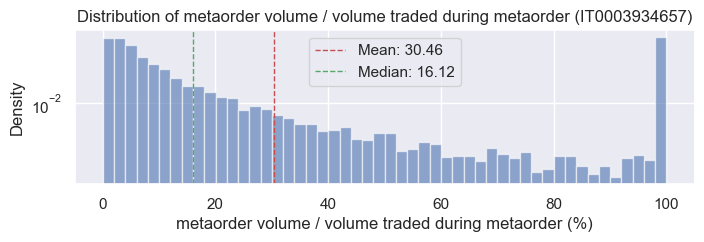

In [18]:
column_positions = {'Trade Time': 3, 'ID Member': 1, 'Total Amount Buy': 9, 'Total Quantity Buy': 7, 'Total Amount Sell': 10, 'Total Quantity Sell': 8, 'ID Client': 0}
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    if os.path.exists(f'out_files/{isin}_metaorders_ratios_{LEVEL}.npy') and RECOMPUTE==False:
        print(f"Metaorders inter times for {isin} already computed.")
        ratios = np.load(f'out_files/{isin}_metaorders_ratios_{LEVEL}.npy')
    else:
        print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].sort_values('Trade Time').reset_index(drop=True)
        trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].sort_values('Trade Time').reset_index(drop=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        ratios = []
        for id in tqdm(metaorders_dict_all[isin].keys(), desc=f'{isin} Agents'):
            l = []
            for i in range(len(metaorders_dict_all[isin][id])):
                met_vol = trades_members.iloc[metaorders_dict_all[isin][id][i]][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
                total_vol_during_met = trades_members.iloc[metaorders_dict_all[isin][id][i][0]:metaorders_dict_all[isin][id][i][-1]+1][['Total Quantity Buy', 'Total Quantity Sell']].sum().sum()
                ratio = met_vol/total_vol_during_met
                ratios.append(ratio)
        
        ratios = np.array(ratios)
        np.save(f'out_files/{isin}_metaorders_ratios_{LEVEL}.npy', ratios)
    
    plt.figure(figsize=(8,2))
    plt.hist(np.array(ratios)*100, bins=50, density=True, alpha=0.6, color='b')
    plt.axvline(np.mean(ratios)*100, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(ratios)*100:.2f}')
    plt.axvline(np.median(ratios)*100, color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(ratios)*100:.2f}')
    plt.title(f"Distribution of metaorder volume / volume traded during metaorder ({isin})")
    plt.xlabel('metaorder volume / volume traded during metaorder (%)')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Signature plots

(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.


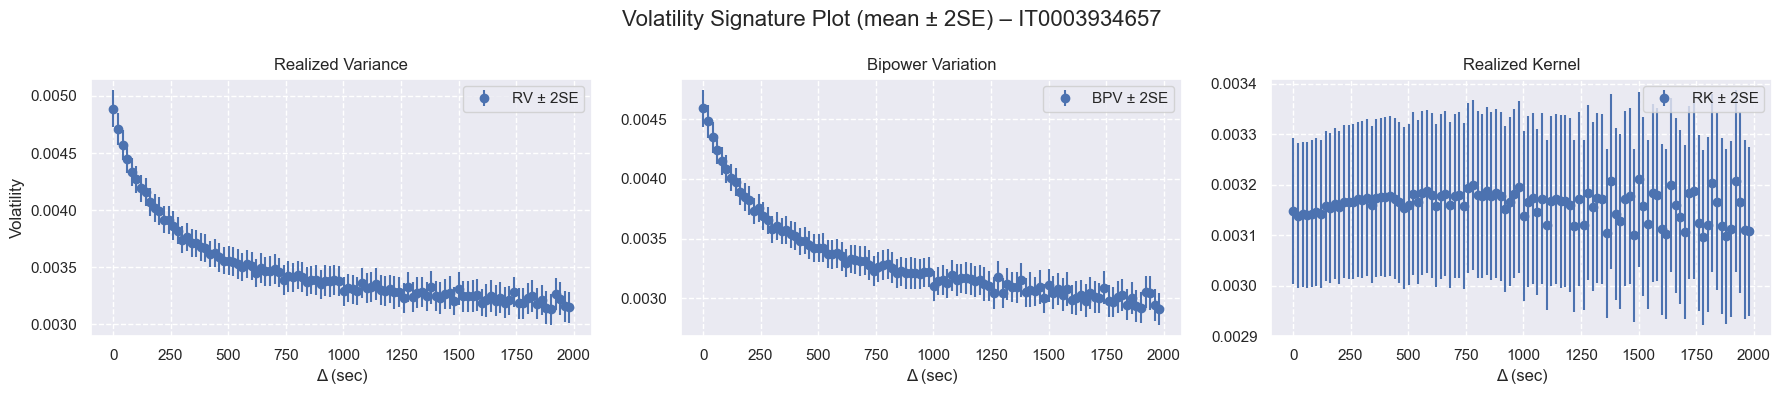

In [19]:
intervals_sec = list(range(1, 2000, 20))
for i, path in enumerate(dfs_path_new[:N]):
    isin = path.split('/')[-1].split('.')[0]
    print(f"({i+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
    print('    Loading trades data...')
    trades_members = pd.read_parquet(f'{path}')
    print(f'   {len(trades_members)} trades loaded.')
    print('    Done.')

    # consider only trades not executed as proprietary trades
    trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].sort_values('Trade Time').reset_index(drop=True)
    trades_members = trades_members[(trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) & (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())].sort_values('Trade Time').reset_index(drop=True)
    print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

    prices = trades_members[['Trade Time', 'Price Last Contract']]

    mean_rv, se_rv = [], []
    mean_bpv, se_bpv = [], []
    mean_rk, se_rk = [], []

    for sec in intervals_sec:
        delta = f'{sec}s'
        log_returns_dict = preprocess_log_returns(prices.copy(), delta)

        rvs = realized_variance_fast(log_returns_dict)
        bpvs = bipower_variation_fast(log_returns_dict)
        rks = realized_kernel_fast(log_returns_dict)

        rvs = np.array(rvs); bpvs = np.array(bpvs); rks = np.array(rks)

        mean_rv.append(np.nanmean(rvs))
        se_rv.append(np.nanstd(rvs, ddof=1) / np.sqrt(np.sum(~np.isnan(rvs))))

        mean_bpv.append(np.nanmean(bpvs))
        se_bpv.append(np.nanstd(bpvs, ddof=1) / np.sqrt(np.sum(~np.isnan(bpvs))))

        mean_rk.append(np.nanmean(rks))
        se_rk.append(np.nanstd(rks, ddof=1) / np.sqrt(np.sum(~np.isnan(rks))))

    fig, axs = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)

    axs[0].errorbar(intervals_sec, mean_rv, yerr=2*np.array(se_rv), fmt='o', label='RV ± 2SE')
    axs[0].set_title('Realized Variance')
    axs[0].set_xlabel('Δ (sec)')
    axs[0].set_ylabel('Volatility')
    # axs[0].set_xscale('log'); axs[0].set_yscale('log')
    axs[0].grid(True, which='both', ls='--'); axs[0].legend()

    axs[1].errorbar(intervals_sec, mean_bpv, yerr=2*np.array(se_bpv), fmt='o', label='BPV ± 2SE')
    axs[1].set_title('Bipower Variation')
    axs[1].set_xlabel('Δ (sec)')
    # axs[1].set_yscale('log'); axs[1].set_xscale('log')
    axs[1].grid(True, which='both', ls='--'); axs[1].legend()

    axs[2].errorbar(intervals_sec, mean_rk, yerr=2*np.array(se_rk), fmt='o', label='RK ± 2SE')
    axs[2].set_title('Realized Kernel')
    axs[2].set_xlabel('Δ (sec)')
    # axs[2].set_yscale('log'); axs[2].set_xscale('log')
    axs[2].grid(True, which='both', ls='--'); axs[2].legend()

    fig.suptitle(f'Volatility Signature Plot (mean ± 2SE) – {isin}', fontsize=16)
    plt.show()



### SQL Fits

Same day

In [20]:
INFO_PATH = f'out_files/metaorders_info_sameday_mot_{LEVEL}.pkl'  # fixed: consistent path

if os.path.exists(f'out_files/metaorders_info_sameday_mot_{LEVEL}.pkl') and RECOMPUTE==False:
    print("Metaorders info already computed.")
    with open(INFO_PATH, 'rb') as f:
        metaorders_info = pickle.load(f)
else:
    print("Computing metaorders info...")
    try:
        with open(f'out_files/metaorders_dict_all_mot_{LEVEL}.pkl', 'rb') as f:
            metaorders_dict_all = pickle.load(f)
    except FileNotFoundError:
        print("Metaorders dict file not found. Please run the metaorders identification script first.")
        raise SystemExit(1)

    metaorders_info = {isin: {} for isin in isins}

    for i_path, path in enumerate(dfs_path_new):
        isin = path.split('/')[-1].split('.')[0]
        print(f"({i_path+1}/{len(dfs_path_new)}) Processing ISIN {isin}...")
        print('    Loading trades data...')
        trades_members = pd.read_parquet(f'{path}')
        print(f'   {len(trades_members)} trades loaded.')
        print('    Done.')

        # consider only trades not executed as proprietary trades & within hours
        trades_members = trades_members[trades_members['Trade Type Aggressive'] != 'Dealing_on_own_account'].copy()
        trades_members = trades_members[
            (trades_members['Trade Time'].dt.time >= pd.to_datetime('09:30:00').time()) &
            (trades_members['Trade Time'].dt.time <= pd.to_datetime('17:30:00').time())
        ].copy()

        # Deterministic, stable order: time + original row-id tiebreaker
        trades_members = trades_members.reset_index(drop=True)
        trades_members['__row_id__'] = np.arange(len(trades_members), dtype=np.int64)
        trades_members.sort_values(['Trade Time', '__row_id__'], kind='mergesort', inplace=True)
        trades_members.reset_index(drop=True, inplace=True)
        print(f'    {len(trades_members)} trades after filtering out proprietary trades and outside trading hours.')

        # --- extract arrays once for fast NumPy indexing ----------------------
        tt: pd.Series = trades_members['Trade Time']
        day_arr = tt.dt.date.values
        plc = trades_members['Price Last Contract'].to_numpy()
        pfc = trades_members['Price First Contract'].to_numpy()
        direction_arr = trades_members['Direction'].to_numpy()
        member_id_arr = trades_members['ID Member'].to_numpy()
        client_id_arr = trades_members['ID Client'].to_numpy()

        q_buy = trades_members['Total Quantity Buy'].to_numpy(dtype=float)
        q_sell = trades_members['Total Quantity Sell'].to_numpy(dtype=float)
        vol_arr = q_buy + q_sell

        # cumulative sums for O(1) contiguous sums (used for volume_during_metaorder)
        csum_vol = np.cumsum(vol_arr)

        # --- cache daily stats once per day -----------------------------------
        daily_cache = build_daily_cache(trades_members)

        # --- main loops --------------------------------------------------------
        metaorders_info[isin] = {}
        for agent_id in tqdm(metaorders_dict_all[isin].keys(), desc='Processing agents'):
            metaorders_info[isin][agent_id] = {}
            meta_list = metaorders_dict_all[isin][agent_id]  # list of lists of row indices

            for idx_meta, idx_list in enumerate(meta_list):
                # metaorder indices in the *global* trades array
                s = idx_list[0]
                e = idx_list[-1]

                start_ts = tt.iloc[s]
                end_ts   = tt.iloc[e]

                # Metaorder volume Q: sum across those exact indices
                metaorder_volume = float(vol_arr[np.asarray(idx_list, dtype=int)].sum())

                # --- FIX: include the last trade in the contiguous window (end is exclusive)
                # We want the market volume during the metaorder execution from s..e inclusive:
                volume_during_metaorder = sum_contiguous(csum_vol, start=s, end_exclusive=e + 1)

                # Direction epsilon (last trade)
                direction = direction_arr[e]

                # daily stats (cached) - metaorders are same-day by construction
                current_day = day_arr[s]
                daily_vol, daily_volume = daily_cache[current_day]

                # log price movement Delta_p: log(PLC_e) - log(PFC_s)
                delta_p = float(np.log(plc[e]) - np.log(pfc[s]))

                # Q / V
                qv = float(metaorder_volume / daily_volume) if daily_volume != 0 else np.nan

                # Participation rate eta = Q / volume_during_metaorder
                eta = float(metaorder_volume / volume_during_metaorder) if volume_during_metaorder != 0 else np.inf

                n_child = len(idx_list)

                # Store tuple (note: third field was 'ID Member' in your original,
                # if you intended 'client' swap to client_id_arr[e] as below)
                metaorders_info[isin][agent_id][idx_meta] = (
                    isin,
                    agent_id,
                    client_id_arr[e],          # <- use client here if that's what you want in the tuple
                    direction,
                    delta_p,
                    daily_vol,
                    float(metaorder_volume),
                    qv,
                    eta,
                    n_child,
                    [start_ts, end_ts],
                )

    # Save
    with open(INFO_PATH, 'wb') as f:
        pickle.dump(metaorders_info, f)


Computing metaorders info...
(1/15) Processing ISIN IT0003934657...
    Loading trades data...
   135433 trades loaded.
    Done.
    98740 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 486/486 [00:00<00:00, 785.00it/s]


(2/15) Processing ISIN IT0005083057...
    Loading trades data...
   67738 trades loaded.
    Done.
    34289 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 194/194 [00:00<00:00, 1774.29it/s]


(3/15) Processing ISIN IT0005217390...
    Loading trades data...
   124738 trades loaded.
    Done.
    66254 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 339/339 [00:00<00:00, 1168.58it/s]


(4/15) Processing ISIN IT0005273013...
    Loading trades data...
   92820 trades loaded.
    Done.
    50585 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 269/269 [00:00<00:00, 2001.48it/s]


(5/15) Processing ISIN IT0005358806...
    Loading trades data...
   99025 trades loaded.
    Done.
    65900 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 291/291 [00:00<00:00, 1429.44it/s]


(6/15) Processing ISIN IT0005363111...
    Loading trades data...
   129570 trades loaded.
    Done.
    73751 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 400/400 [00:00<00:00, 1877.19it/s]


(7/15) Processing ISIN IT0005425233...
    Loading trades data...
   141844 trades loaded.
    Done.
    75887 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 366/366 [00:00<00:00, 856.64it/s]


(8/15) Processing ISIN IT0005438004...
    Loading trades data...
   58730 trades loaded.
    Done.
    30508 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 140/140 [00:00<00:00, 2471.26it/s]


(9/15) Processing ISIN IT0005441883...
    Loading trades data...
   185801 trades loaded.
    Done.
    111785 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 595/595 [00:00<00:00, 703.20it/s]


(10/15) Processing ISIN IT0005480980...
    Loading trades data...
   62799 trades loaded.
    Done.
    27018 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 136/136 [00:00<00:00, 1808.14it/s]


(11/15) Processing ISIN IT0005496770...
    Loading trades data...
   59577 trades loaded.
    Done.
    32615 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 170/170 [00:00<00:00, 2716.67it/s]


(12/15) Processing ISIN IT0005530032...
    Loading trades data...
   63843 trades loaded.
    Done.
    26544 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 171/171 [00:00<00:00, 3296.08it/s]


(13/15) Processing ISIN IT0005534141...
    Loading trades data...
   154098 trades loaded.
    Done.
    66535 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 434/434 [00:00<00:00, 2349.31it/s]


(14/15) Processing ISIN IT0005582421...
    Loading trades data...
   72447 trades loaded.
    Done.
    36730 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 227/227 [00:00<00:00, 4203.27it/s]


(15/15) Processing ISIN IT0005583486...
    Loading trades data...
   48939 trades loaded.
    Done.
    37081 trades after filtering out proprietary trades and outside trading hours.


Processing agents: 100%|██████████| 231/231 [00:00<00:00, 1766.67it/s]


In [21]:
rows = [
    (isin, id, client, direction, pct, daily_vol, q, qv, eta, n_child, period)
    for isin_dict in metaorders_info.values()
    for member_dict in isin_dict.values()
    for isin, id, client, direction, pct, daily_vol, q, qv, eta, n_child, period in member_dict.values()
]

metaorders_info_df_sameday = pd.DataFrame(rows, columns=('ISIN', 'Member', 'Client', 'Direction', 'Price Change', 'Daily Vol', 'Q', 'Q/V', 'Participation Rate', 'N Child', 'Period'))
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0003934657,1633,1633,1,-0.004158,0.083712,285000.0,0.005149,0.006940,19,"[2024-06-11 10:00:21.168672100, 2024-06-11 15:..."
1,IT0003934657,1633,1633,1,0.000807,0.078881,76000.0,0.002118,0.027427,3,"[2024-06-12 09:33:19.779664755, 2024-06-12 09:..."
2,IT0003934657,1633,1633,1,0.000202,0.078881,28000.0,0.000780,0.007473,3,"[2024-06-12 11:02:21.353040415, 2024-06-12 11:..."
3,IT0003934657,1633,1633,1,-0.003298,0.067533,113000.0,0.002956,0.008438,5,"[2024-06-14 10:03:41.592663111, 2024-06-14 13:..."
4,IT0003934657,1633,1633,-1,0.000698,0.067533,159000.0,0.004159,0.013132,4,"[2024-06-14 15:41:11.578785008, 2024-06-14 17:..."
...,...,...,...,...,...,...,...,...,...,...,...
54219,IT0005583486,1016991848,1016991848,-1,0.000000,0.023176,55000.0,0.017383,1.000000,2,"[2025-05-13 11:38:44.508184707, 2025-05-13 11:..."
54220,IT0005583486,202330006,202330006,-1,0.000000,0.035598,527000.0,0.150658,0.947842,4,"[2025-05-20 14:33:40.666826543, 2025-05-20 14:..."
54221,IT0005583486,140124068,140124068,-1,-0.000096,0.037142,50000.0,0.012207,0.396825,2,"[2025-05-21 09:30:06.356943359, 2025-05-21 09:..."
54222,IT0005583486,21226219,21226219,-1,0.000192,0.029211,4000.0,0.000417,0.006504,2,"[2025-05-27 09:30:55.658813257, 2025-05-27 09:..."


In [22]:
# Filter metaorders with time horizon >= 60 seconds
metaorders_info_df_sameday = metaorders_info_df_sameday[
    metaorders_info_df_sameday['Period'].apply(
        lambda period: (period[1] - period[0]).total_seconds() >= 60
    )
].reset_index(drop=True)
metaorders_info_df_sameday

,ISIN,Member,Client,Direction,Price Change,Daily Vol,Q,Q/V,Participation Rate,N Child,Period
0,IT0003934657,1633,1633,1,-0.004158,0.083712,285000.0,0.005149,0.006940,19,"[2024-06-11 10:00:21.168672100, 2024-06-11 15:..."
1,IT0003934657,1633,1633,1,0.000807,0.078881,76000.0,0.002118,0.027427,3,"[2024-06-12 09:33:19.779664755, 2024-06-12 09:..."
2,IT0003934657,1633,1633,1,0.000202,0.078881,28000.0,0.000780,0.007473,3,"[2024-06-12 11:02:21.353040415, 2024-06-12 11:..."
3,IT0003934657,1633,1633,1,-0.003298,0.067533,113000.0,0.002956,0.008438,5,"[2024-06-14 10:03:41.592663111, 2024-06-14 13:..."
4,IT0003934657,1633,1633,-1,0.000698,0.067533,159000.0,0.004159,0.013132,4,"[2024-06-14 15:41:11.578785008, 2024-06-14 17:..."
...,...,...,...,...,...,...,...,...,...,...,...
47973,IT0005583486,1066497178,1066497178,-1,-0.000385,0.039534,300000.0,0.114373,0.626305,3,"[2025-05-02 09:32:12.770213031, 2025-05-02 09:..."
47974,IT0005583486,181997508,181997508,-1,0.000000,0.027362,14000.0,0.004781,0.157303,3,"[2025-05-05 11:02:20.870579962, 2025-05-05 11:..."
47975,IT0005583486,202330006,202330006,-1,0.000000,0.035598,527000.0,0.150658,0.947842,4,"[2025-05-20 14:33:40.666826543, 2025-05-20 14:..."
47976,IT0005583486,140124068,140124068,-1,-0.000096,0.037142,50000.0,0.012207,0.396825,2,"[2025-05-21 09:30:06.356943359, 2025-05-21 09:..."


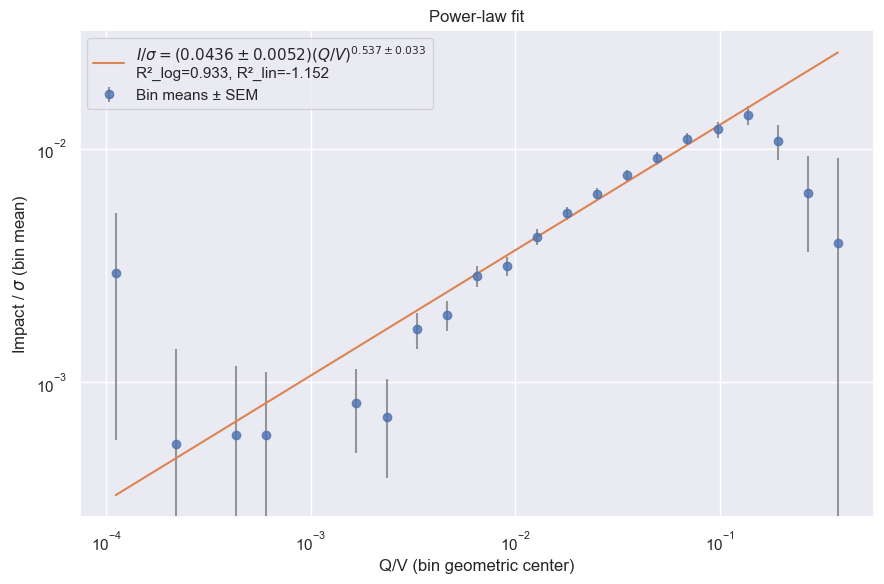

--- Overall (All) ---
Y = 0.0436251 ± 0.00525
γ = 0.536767 ± 0.0331
R²_log = 0.9327 | R²_lin = -1.1516
Bins used: 21 (min_count ≥ 20)


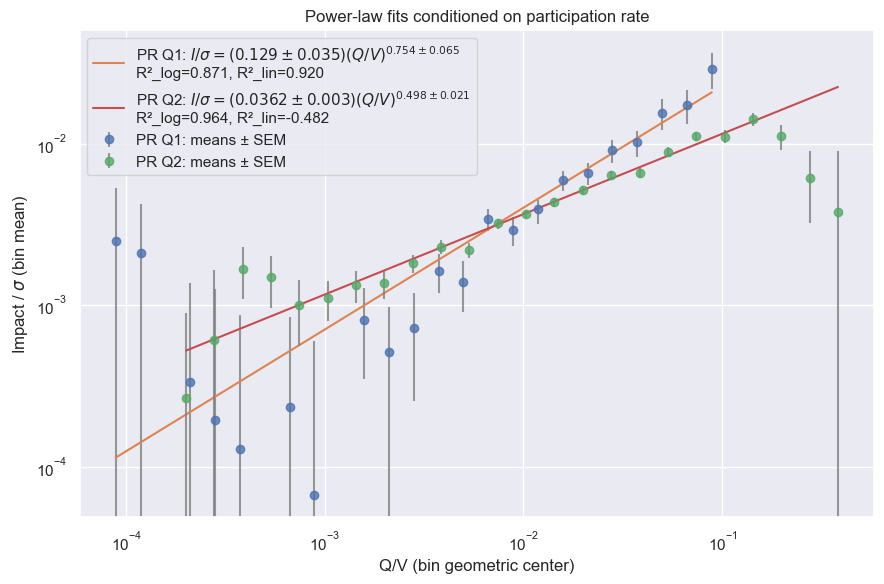

--- Conditioned on Participation Rate ---
[PR Q1]  Y = 0.129433 ± 0.0352 | γ = 0.754149 ± 0.065 | R²_log = 0.8707 | R²_lin = 0.9196
[PR Q2]  Y = 0.0362356 ± 0.00297 | γ = 0.497602 ± 0.0206 | R²_log = 0.9638 | R²_lin = -0.4817


In [26]:
df = metaorders_info_df_sameday.copy()
df['Impact'] = df['Price Change'] * df['Direction'] / df['Daily Vol']
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Q/V', 'Impact'])
df = df[df['Q/V'] > 0]  # strictly positive for log space

# ----------------------------
# Utilities
# ----------------------------
def power_law(qv, Y, gamma):
    """I/sigma = Y * (Q/V)^gamma"""
    return Y * np.power(qv, gamma)

def fit_power_law_logbins_wls(
    subdf: pd.DataFrame,
    n_logbins: int = 30,
    min_count: int = 100,        # reliability filter: keep only bins with enough obs
    use_median: bool = False     # set True for robustness; paper uses conditional averages (means)
):
    """
    Bin on a fixed log grid in Q/V, compute conditional mean Impact per bin,
    estimate Y, gamma in log–log space via weighted least squares:
        log(I) = log(Y) + gamma * log(Q/V)
    with weights w = 1 / Var[log(mean_imp)] ≈ (mean_imp / SEM)^2.

    Returns:
        binned_df: DataFrame with center_QV, mean_imp, sem_imp, count
        params   : (Y, Y_se, gamma, gamma_se, R2_log, R2_lin)
    """
    sub = subdf[(subdf['Q/V'] > 0) & np.isfinite(subdf['Impact'])].copy()
    if sub.empty:
        raise ValueError("No valid rows (Q/V>0 and finite Impact).")

    x = sub['Q/V'].to_numpy()
    y = sub['Impact'].to_numpy()

    # Fixed log grid on observed support
    x_min = x.min()
    x_max = x.max()
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
        raise ValueError("Invalid Q/V range for log binning.")
    edges = np.logspace(np.log10(x_min), np.log10(x_max), n_logbins + 1)

    # Assign bins
    bin_idx = np.digitize(x, edges) - 1
    mask = (bin_idx >= 0) & (bin_idx < n_logbins)
    x, y, bin_idx = x[mask], y[mask], bin_idx[mask]

    # --- Aggregate in each bin (robust to empty bins) ---
    dfb = pd.DataFrame({'x': x, 'y': y, 'bin': bin_idx})

    agg = (
        dfb.groupby('bin')['y']
           .agg(mean_imp='mean',
                median_imp='median',
                std_imp=lambda s: s.std(ddof=1),
                count='size')
           .sort_index()
    )

    # choose mean/median for the fit
    y_stat = agg['median_imp'] if use_median else agg['mean_imp']
    y_std  = agg['std_imp'].to_numpy()
    n      = agg['count'].to_numpy()
    sem    = y_std / np.sqrt(np.maximum(n, 1))

    # geometric centers for the *present* bins only
    bins_present = agg.index.to_numpy()
    left_edges   = edges[bins_present]
    right_edges  = edges[bins_present + 1]
    x_center     = np.sqrt(left_edges * right_edges)

    binned = pd.DataFrame({
        'center_QV': x_center,
        'mean_imp':  y_stat.to_numpy(),
        'std_imp':   y_std,
        'sem_imp':   sem,
        'count':     n
    }).sort_values('center_QV').reset_index(drop=True)

    # Reliability & positivity filters for log fit
    binned = binned[
        (binned['count'] >= min_count) &
        np.isfinite(binned['mean_imp']) &
        np.isfinite(binned['sem_imp']) &
        (binned['sem_imp'] > 0) &
        (binned['mean_imp'] > 0)
    ]
    if len(binned) < 3:
        raise ValueError(f"Not enough valid bins after filtering (got {len(binned)}). "
                         f"Try lowering min_count or n_logbins.")

    X = np.log(binned['center_QV'].to_numpy())
    Z = np.log(binned['mean_imp'].to_numpy())

    # Delta-method weights: Var[log(mean_imp)] ≈ (SEM/mean)^2  => w = 1/Var
    var_logy = (binned['sem_imp'].to_numpy() / binned['mean_imp'].to_numpy())**2
    w = 1.0 / var_logy
    w = np.where(np.isfinite(w) & (w > 0), w, 0)

    # Weighted least squares for Z = a + gamma * X  (Y = exp(a))
    A = np.vstack([np.ones_like(X), X]).T
    Aw = A * np.sqrt(w)[:, None]
    Zw = Z * np.sqrt(w)
    coef, _, _, _ = np.linalg.lstsq(Aw, Zw, rcond=None)
    a_hat, gamma_hat = coef
    Y_hat = np.exp(a_hat)

    # Covariance of coefficients: cov ≈ sigma^2 * (X' W X)^(-1), sigma^2 from weighted residuals
    res  = Z - (a_hat + gamma_hat * X)
    RSS  = np.sum(w * res**2)
    dof  = max(len(Z) - 2, 1)
    s2   = RSS / dof
    XtWX = A.T @ (w[:, None] * A)
    cov  = s2 * np.linalg.inv(XtWX)
    a_se, gamma_se = np.sqrt(np.diag(cov))
    Y_se = Y_hat * a_se  # delta-method

    # R^2 on log scale (weighted) and on original scale (unweighted, for intuition)
    Zhat = a_hat + gamma_hat * X
    Zbar = np.average(Z, weights=w)
    R2_log = 1.0 - np.sum(w * (Z - Zhat)**2) / np.sum(w * (Z - Zbar)**2)

    yhat   = power_law(binned['center_QV'].to_numpy(), Y_hat, gamma_hat)
    ybar   = np.mean(binned['mean_imp'].to_numpy())
    R2_lin = 1.0 - np.sum((binned['mean_imp'].to_numpy() - yhat)**2) / np.sum((binned['mean_imp'].to_numpy() - ybar)**2)

    return binned, (Y_hat, Y_se, gamma_hat, gamma_se, R2_log, R2_lin)

def plot_fit(ax, binned: pd.DataFrame, params, label_prefix=None):
    """Scatter with SEM bars and fitted curve on log–log axes."""
    Y, Y_err, gamma, gamma_err, R2_log, R2_lin = params

    ax.errorbar(
        binned['center_QV'],
        binned['mean_imp'],
        yerr=binned['sem_imp'],
        fmt='o', alpha=0.8, ecolor='gray',
        label='Bin means ± SEM' if label_prefix is None else f'{label_prefix}: means ± SEM'
    )

    x_min, x_max = binned['center_QV'].min(), binned['center_QV'].max()
    x_grid = np.logspace(np.log10(x_min), np.log10(x_max), 300)
    ax.plot(
        x_grid, power_law(x_grid, Y, gamma),
        label=(rf'{"" if label_prefix is None else label_prefix + ": "}'
               rf'$I/\sigma = ({Y:.3g}\pm{Y_err:.2g})(Q/V)^{{{gamma:.3f}\pm{gamma_err:.3f}}}$'
               f'\nR²_log={R2_log:.3f}, R²_lin={R2_lin:.3f}')
    )

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Q/V (bin geometric center)')
    ax.set_ylabel(r'Impact / $\sigma$ (bin mean)')
    ax.legend(loc='best')

# ----------------------------
# 1) Overall fit (all metaorders)
# ----------------------------
n_logbins = 30
min_count = 20  # raise for larger datasets; lower if data is sparse

binned_all, params_all = fit_power_law_logbins_wls(
    df, n_logbins=n_logbins, min_count=min_count, use_median=False
)

fig, ax = plt.subplots(figsize=(9, 6))
plot_fit(ax, binned_all, params_all)
ax.set_title('Power-law fit')
plt.tight_layout()
plt.savefig(f'images/power_law_fit_overall_mot_{LEVEL}.png', dpi=300)
plt.show()

print('--- Overall (All) ---')
print(f'Y = {params_all[0]:.6g} ± {params_all[1]:.3g}')
print(f'γ = {params_all[2]:.6f} ± {params_all[3]:.3g}')
print(f'R²_log = {params_all[4]:.4f} | R²_lin = {params_all[5]:.4f}')
print(f'Bins used: {len(binned_all)} (min_count ≥ {min_count})')

# ----------------------------
# 2) Conditioning on Participation Rate
# ----------------------------
PR_CANDIDATES = 'Participation Rate'

# Define participation-rate groups via quantiles (change nbins if needed)
pr_nbins = 2
labels = [f'Q{j+1}' for j in range(pr_nbins)]
df = df.copy()
df['PR_bin'] = pd.qcut(df[PR_CANDIDATES], q=pr_nbins, labels=labels, duplicates='drop')

# Fit and plot one curve per PR bin using the *same* WLS procedure
fig, ax = plt.subplots(figsize=(9, 6))
legend_entries = []
fits_by_pr = {}

for label in df['PR_bin'].dropna().unique():
    sub = df[df['PR_bin'] == label]
    try:
        binned_sub, params_sub = fit_power_law_logbins_wls(
            sub, n_logbins=n_logbins, min_count=min_count, use_median=False
        )
    except Exception as e:
        print(f"[{label}] skipped: {e}")
        continue

    plot_fit(ax, binned_sub, params_sub, label_prefix=f'PR {label}')
    fits_by_pr[str(label)] = params_sub

ax.set_title(f'Power-law fits conditioned on participation rate')
plt.tight_layout()
plt.savefig(f'images/power_law_fits_by_participation_rate_mot_{LEVEL}.png', dpi=300)
plt.show()
print('--- Conditioned on Participation Rate ---')
for k, (Y, Y_se, gamma, gamma_se, R2_log, R2_lin) in fits_by_pr.items():
    print(f"[PR {k}]  Y = {Y:.6g} ± {Y_se:.3g} | γ = {gamma:.6f} ± {gamma_se:.3g} | "
          f"R²_log = {R2_log:.4f} | R²_lin = {R2_lin:.4f}")
